<a href="https://colab.research.google.com/github/oyshisarker2001/Neuromarketing-Taste-Classification/blob/main/taste_Bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import scipy.io
import os
import numpy as np
import pandas as pd

folder_path = '/content/drive/My Drive/taste_datasets'  # Update as needed
files = [f for f in os.listdir(folder_path) if f.endswith('.mat')]

all_segments = []
all_labels = []
label_log = []  # To track filename and assigned label per segment

for fname in files:
    data = scipy.io.loadmat(os.path.join(folder_path, fname))

    # Check variable names as saved from MATLAB
    if 'segments_permuted' in data and 'labels' in data:
        segments = data['segments_permuted']  # shape: (segments, time_steps, channels)
        labels = data['labels'].flatten()     # typically MATLAB cell array

        # Convert MATLAB cell to list of strings
        labels_list = [str(l[0]) if isinstance(l, np.ndarray) else str(l) for l in labels]
        labels_list = ['Sweet' if label == 'Sugar' else label for label in labels_list]

        all_segments.append(segments)
        all_labels.extend(labels_list)
        for segment_label in labels_list:
            label_log.append({'filename': fname, 'label': segment_label})
    else:
        print(f"Warning: {fname} missing 'segments_permuted' or 'labels', skipping.")

# After processing all files, concatenate all segments
all_segments = np.concatenate(all_segments, axis=0)

# Convert labels list to numpy array of dtype object (for saving)
all_labels = np.array(all_labels, dtype=object)

# Save combined arrays as a new .mat file
scipy.io.savemat('All_Preprocessed_fNIRS.mat',
                 {'all_segments': all_segments, 'all_labels': all_labels})

label_log_df = pd.DataFrame(label_log)
label_log_df.to_csv('label_mapping_log.csv', index=False)


print(f"Total segments combined: {all_segments.shape[0]}")
print(f"Shape of all_segments: {all_segments.shape}")
print(f"Number of labels: {len(all_labels)}")
print(f"Label log saved as 'label_mapping_log.csv'")

data = scipy.io.loadmat('All_Preprocessed_fNIRS.mat')

X = data['all_segments']  # shape: (samples, time_steps, channels)
labels = data['all_labels'].flatten()  # flatten to 1D array if needed

# Convert MATLAB cells or bytes to strings
labels = [str(l[0]) if (isinstance(l, np.ndarray) or isinstance(l, bytes)) else str(l) for l in labels]

print(f"Data shape: {X.shape}")
print(f"Number of labels: {len(labels)}")
print(f"Classes: {set(labels)}")


Total segments combined: 544
Shape of all_segments: (544, 1000, 16)
Number of labels: 544
Label log saved as 'label_mapping_log.csv'
Data shape: (544, 1000, 16)
Number of labels: 544
Classes: {'Sour', 'Bitter', 'Sweet', 'Umami', 'Salty'}


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_int = le.fit_transform(labels)   # Convert string labels to integers
y_cat = to_categorical(y_int)      # One-hot encoding

print(f"Label classes: {le.classes_}")
print(f"One-hot label shape: {y_cat.shape}")

Label classes: ['Bitter' 'Salty' 'Sour' 'Sweet' 'Umami']
One-hot label shape: (544, 5)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_int)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")


Training samples: 435, Validation samples: 109


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1000, 128)      │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,013 (324.27 KB)

 Trainable params: 83,013 (324.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6293 - loss: 0.8968 - val_accuracy: 0.6422 - val_loss: 0.9352
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7260 - loss: 0.7158 - val_accuracy: 0.7064 - val_loss: 0.8790
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7081 - loss: 0.6974 - val_accuracy: 0.7156 - val_loss: 0.8508
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7635 - loss: 0.5845 - val_accuracy: 0.7064 - val_loss: 0.7660
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7491 - loss: 0.6015 - val_accuracy: 0.7431 - val_loss: 0.7133
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7690 - loss: 0.5327 - val_accuracy: 0.7431 - val_loss: 0.7222
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7924 - loss: 0.4912 - val_accuracy: 0.7615 - val_loss: 0.6949
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8225 - loss: 0.4604 - val_accuracy: 0.7431 - val_loss:

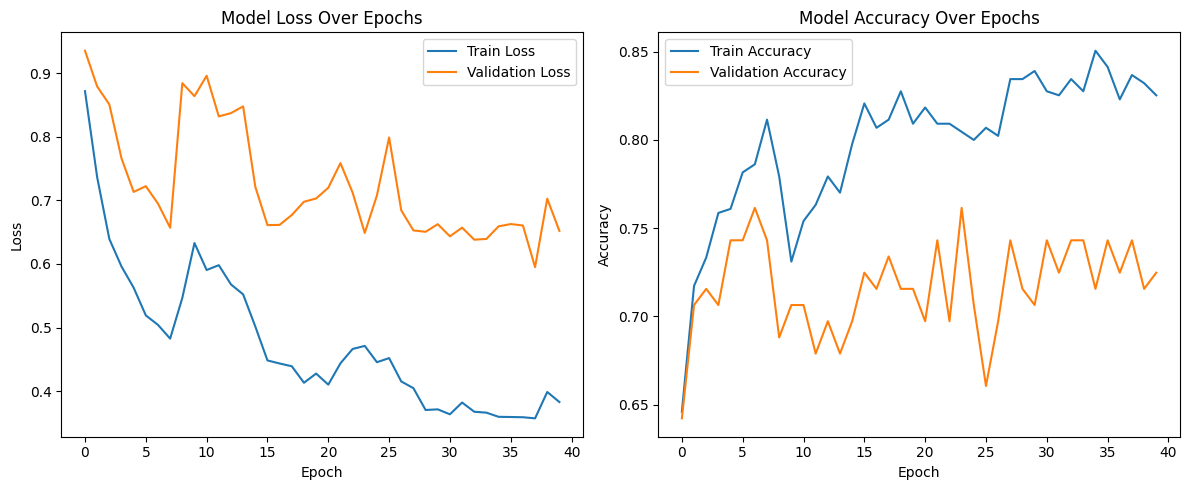

In [ ]:
import matplotlib.pyplot as plt

history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val)
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step
Classification Report:
              precision    recall  f1-score   support

      Bitter       0.51      0.90      0.66        21
       Salty       0.81      0.77      0.79        22
        Sour       0.94      0.70      0.80        23
       Sweet       0.82      0.64      0.72        22
       Umami       0.76      0.62      0.68        21

    accuracy                           0.72       109
   macro avg       0.77      0.73      0.73       109
weighted avg       0.77      0.72      0.73       109

Confusion Matrix:
 [[19  0  1  1  0]
 [ 5 17  0  0  0]
 [ 4  0 16  1  2]
 [ 3  3  0 14  2]
 [ 6  1  0  1 13]]


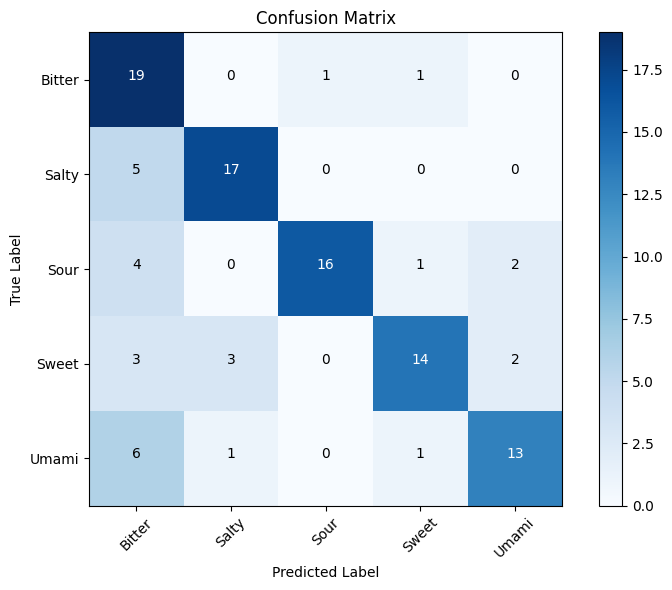

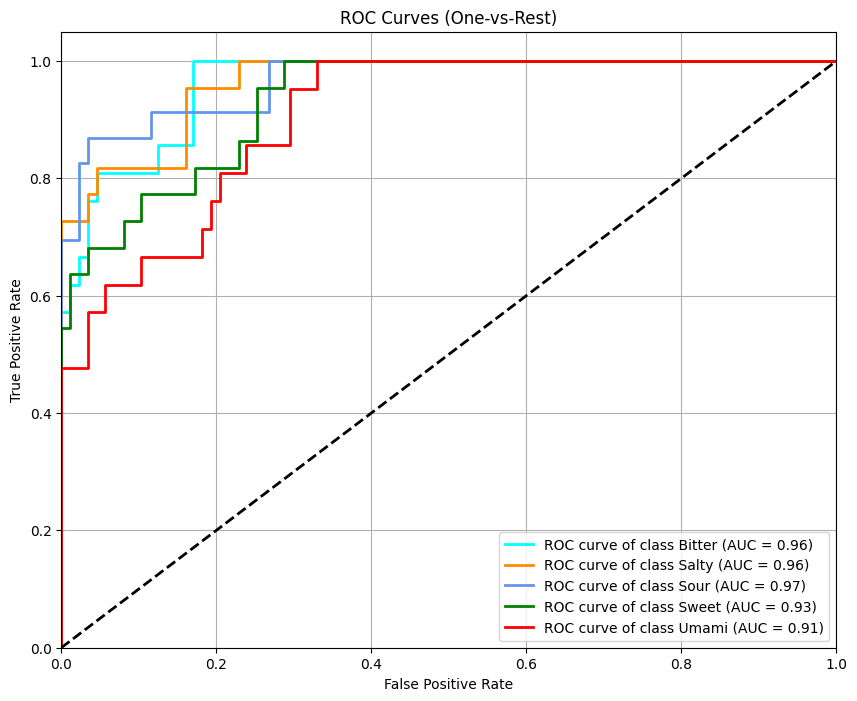

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from itertools import cycle

# 1. Get predicted probabilities and predicted classes
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# 2. Print classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# 3. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# 4. Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)

# Annotate each cell with counts
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# 5. Plot ROC curves and compute AUC for each class (one-vs-rest)
n_classes = y_val.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
print("Max training accuracy over epochs:", max(history.history['accuracy']))
print("Max validation accuracy over epochs:", max(history.history['val_accuracy']))


Max training accuracy over epochs: 0.8505747318267822
Max validation accuracy over epochs: 0.7614678740501404


In [ ]:
model.save('fNIRS_transformer_model.h5')